In [2]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import BBG_data_process_funcs as data_process
import risk_free_curve as rfcurve

### Pricing as of 21 Sep 2018

In [3]:
pdate = dt.datetime.strptime('2018/09/21', "%Y/%m/%d")
pdate_string = pdate.strftime('%d%b%Y')

#### Convertible Bond input data from Bloomberg

In [4]:
inputfile = 'AndersonBuffum_PricingInput_Test_20in30SoftCall.xlsx'

cb_data = pd.read_excel(inputfile,sheet_name=0)
cb_data = cb_data.iloc[1:]
cb_data['MATURITY'] = pd.to_datetime(cb_data['MATURITY'])

cds_data = pd.read_excel(inputfile,sheet_name='CDS Curves')

call_put_schedule_data = pd.read_excel(inputfile,sheet_name='Call Put Schedule')
cp_schedules = data_process.process_call_put_schedule_data(call_put_schedule_data)

#### Risk free discount curve constructed from Bloomberg Data

In [5]:
rf_tenor_tickers = pd.read_excel(inputfile, sheet_name='IR Term TICKERS').set_index('TICKER')
rf_tenor_dict = rf_tenor_tickers['YEARS'].to_dict()

rf_rates_data = pd.read_excel(inputfile, sheet_name='IR Term Structure')
rf_rates_data = rf_rates_data.iloc[6:]
rf_rates_data.columns = np.insert(rf_rates_data.columns[1:],0,'Dates')
rf_rates_data = rf_rates_data.set_index('Dates')

def construct_rf_curve(pricing_date: dt.datetime):
    pdate_rf_rates = rf_rates_data.loc[pdate]
    rf_tenors = np.array([rf_tenor_dict[i] for i in pdate_rf_rates.index])
    rf_zrates = pdate_rf_rates.values/100.
    rf_curve = rfcurve.risk_free_curve(rf_tenors, rf_zrates)
    return rf_curve

rf_curve = construct_rf_curve(pdate)

####  Compare with Bloomberg Convertible Bond Data

In [6]:
p = 0.0

In [7]:
cb_data.iloc[0]

ISIN                                       US62957HAB15
BOND_TO_EQY_TICKER                               NBR US
CONTINGENT_CNVS_TRIGGER                             130
NAME                              NABORS INDUSTRIES INC
PX_LAST                                          78.375
Fair Value                                        74.93
CV_MODEL_UNDL_PX                                   6.25
EQY_DVD_YLD_IND                                  3.8462
CV_CNVS_PX                                       25.158
CV_CNVS_RATIO                                   39.7488
PAR_AMT                                            1000
CPN                                                0.75
CPN_FREQ                                              2
MATURITY                            2024-01-15 00:00:00
BOND_RECOVERY_RATE                                  0.4
DAY_CNT_DES                                      30/360
CV_MODEL_STOCK_VOL                              47.8429
FLAT_CREDIT_SPREAD_CV_MODEL                     

In [8]:
test_cb_data = cb_data.iloc[0].to_dict()
S_range = np.arange(5,51,5)

prices_scon = []
deltas_scon = []

prices_scoff = []
deltas_scoff = []

for S in S_range:
    test_cb_data['CV_MODEL_UNDL_PX'] = S

    test_cb_data['SOFT CALL 20-30'] = 'Y'
    results = data_process.ABpricer_on_BBG_data(test_cb_data,pdate,cds_data,cp_schedules,rf_curve,p=0)    
    prices_scon.append(results[0])
    deltas_scon.append(results[1])

    test_cb_data['SOFT CALL 20-30'] = 'N'
    results = data_process.ABpricer_on_BBG_data(test_cb_data,pdate,cds_data,cp_schedules,rf_curve,p=0)    
    prices_scoff.append(results[0])
    deltas_scoff.append(results[1])

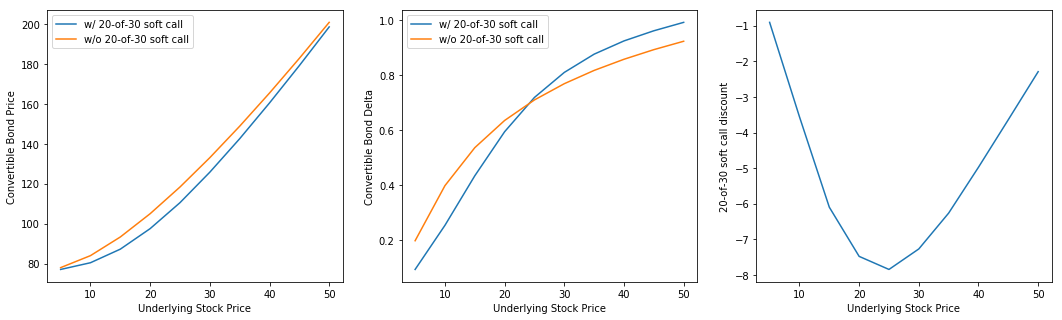

In [9]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(S_range,prices_scon, label='w/ 20-of-30 soft call')
plt.plot(S_range,prices_scoff,label='w/o 20-of-30 soft call')
plt.xlabel('Underlying Stock Price')
plt.ylabel('Convertible Bond Price')
plt.legend()

plt.subplot(1,3,2)
plt.plot(S_range,deltas_scon, label='w/ 20-of-30 soft call')
plt.plot(S_range,deltas_scoff,label='w/o 20-of-30 soft call')
plt.xlabel('Underlying Stock Price')
plt.ylabel('Convertible Bond Delta')
plt.legend()

plt.subplot(1,3,3)
plt.plot(S_range, [a-b for a,b in zip(prices_scon,prices_scoff)])
plt.xlabel('Underlying Stock Price')
plt.ylabel('20-of-30 soft call discount')

plt.show()